   Assets  Mean Returns (%)  Volatility (%)
0       1          4.370861        0.733992
1       2          9.556429        0.587125
2       3          7.587945        1.799264
3       4          6.387926        1.401673
4       5          2.404168        1.562109
Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49
Generation 50
Generation 51
Generation 52
Gene

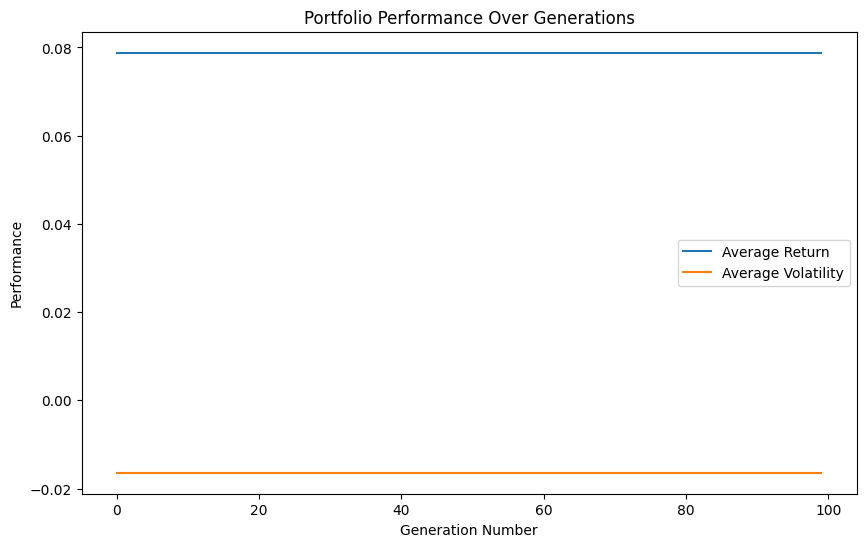

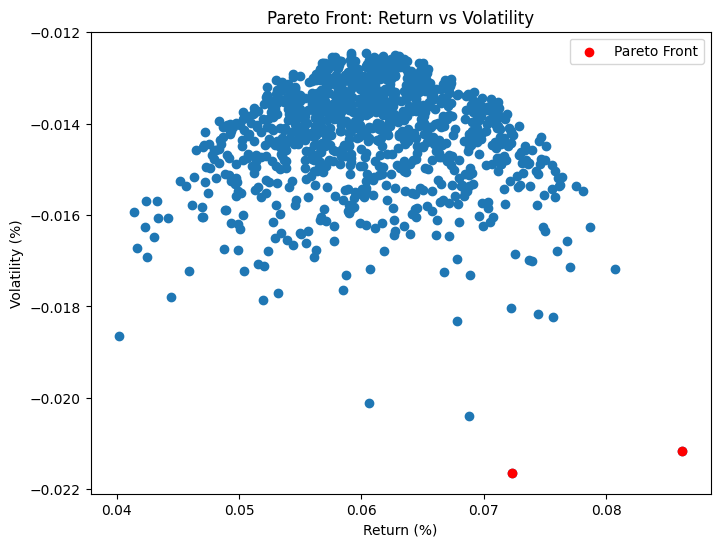

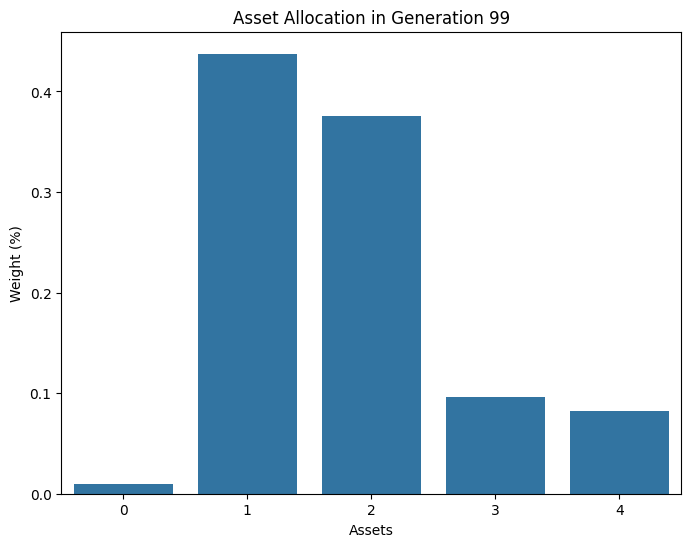

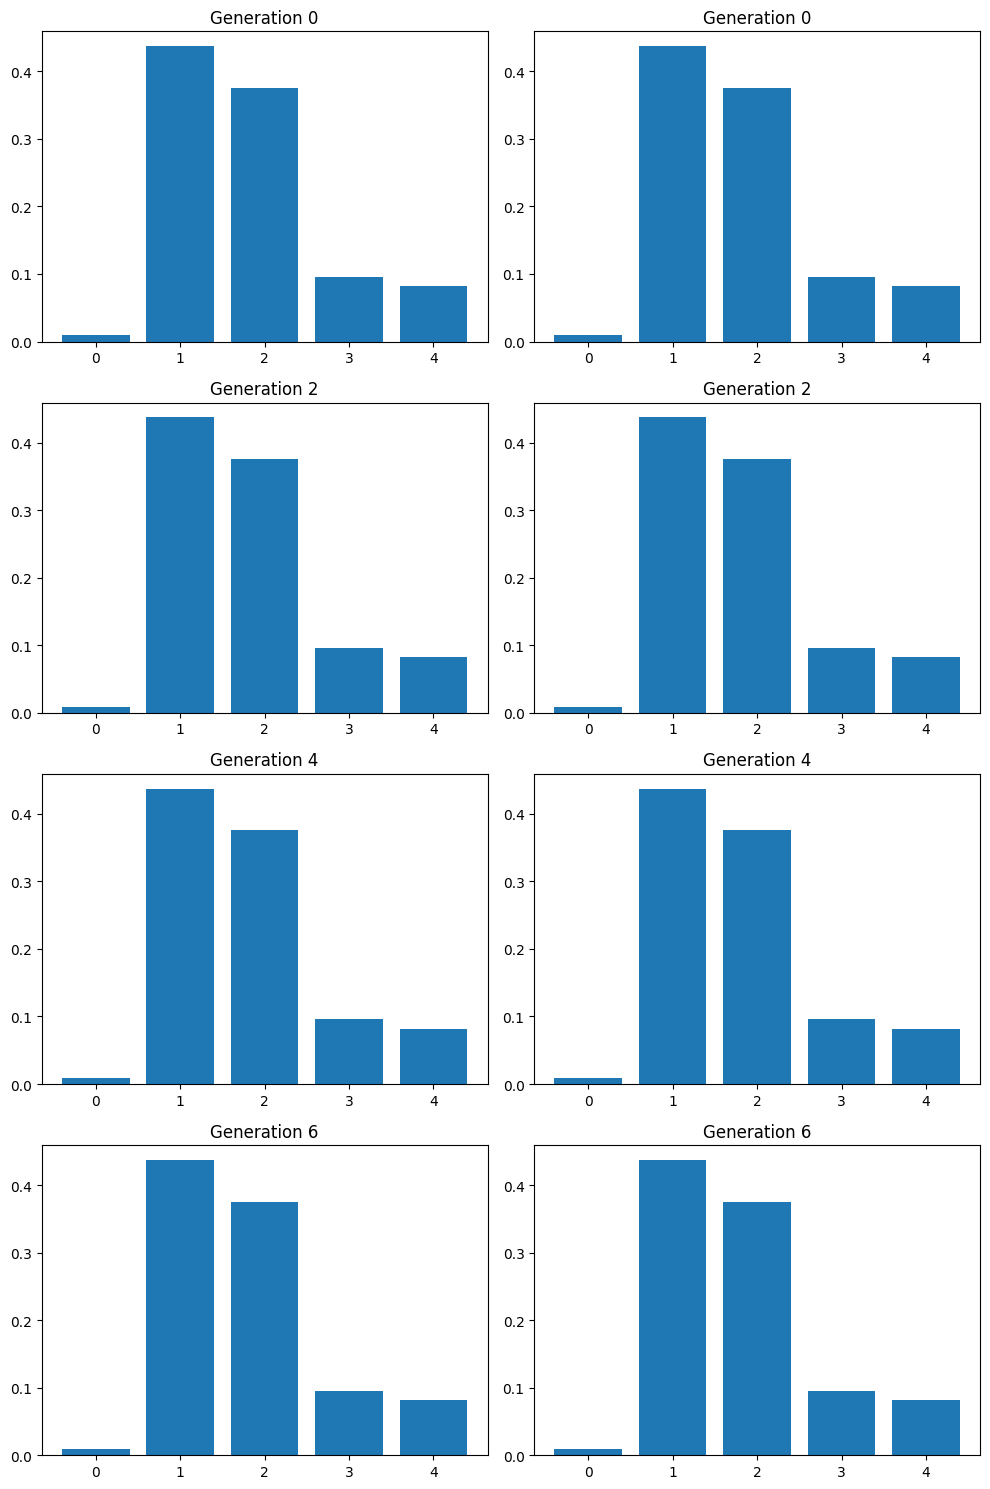

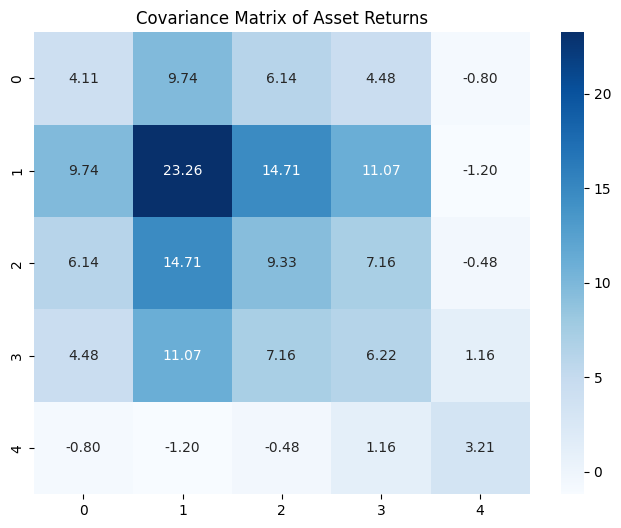

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install deap
from deap import base, tools, algorithms


np.random.seed(42)
n_assets = 5
n_generations = 100
population_size = 30

# Generating random returns (for demonstration purposes)
returns_mean = np.random.uniform(low=0.01, high=0.1, size=n_assets)
returns_std = np.random.uniform(low=0.005, high=0.02, size=n_assets)

df_returns = pd.DataFrame({
    'Assets': range(1, n_assets+1),
    'Mean Returns (%)': returns_mean*100,
    'Volatility (%)': returns_std*100
})

print(df_returns)

def calculate_portfolio_performance(weights, returns):
    # Calculate portfolio return
    port_return = np.sum(returns * weights)

    # Calculate portfolio volatility
    cov_matrix = np.cov(returns)  # Assuming we have a covariance matrix
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    return (port_return, -port_volatility)

# Function to evaluate all individuals in the population
def evalPortfolio(individual):
    returns = df_returns['Mean Returns (%)'].values / 100  # Convert to decimal
    if len(individual) != len(returns):
        raise ValueError("The individual length does not match the number of assets.")

    weights = np.array(individual)
    # Ensure sum of weights is 1 and no negative weights
    if abs(np.sum(weights) - 1.0) > 0.001 or (weights < 0).any():
        return (0.0, 0.0)  # Invalid portfolio

    return calculate_portfolio_performance(weights, returns)

# Random population initialization
def random_weights():
    weights = np.random.random(n_assets)
    weights /= sum(weights)  # Ensure sum is 1
    return tuple(weights)

toolbox = base.Toolbox()
toolbox.register("weights", random_weights)
toolbox.register("evaluate", evalPortfolio)

# Genetic operators for real numbers
toolbox.register("mutate", tools.mutGaussian, mu=0.5, sigma=0.2, indpb=0.5)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=0, high=1, indpb=0.5)

# Algorithm setup
population = [toolbox.weights() for _ in range(population_size)]

import concurrent.futures

def main():
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = [toolbox.evaluate(individual) for individual in population]

    # Sort the population based on fitness
    pop = sorted(zip(population, results), key=lambda x: (x[1][0], -x[1][1]))

    # Selecting the best individuals for next generation
    selected = [pop[i][0] for i in range(population_size)]

    return selected

# Evolve the population
best_portfolios = []
for gen in range(n_generations):
    print(f"Generation {gen}")
    population = main()
    best_portfolio = max(population, key=lambda x: (evalPortfolio(x)[0], -evalPortfolio(x)[1]))
    best_portfolios.append(best_portfolio)

# Calculate performance metrics for each generation
generation_returns = []
generation_vols = []

for portfolio in best_portfolios:
    returns, vol = evalPortfolio(portfolio)
    generation_returns.append(returns)
    generation_vols.append(vol)

plt.figure(figsize=(10, 6))
plt.plot(range(n_generations), generation_returns, label='Average Return')
plt.plot(range(n_generations), generation_vols, label='Average Volatility')
plt.title('Portfolio Performance Over Generations')
plt.xlabel('Generation Number')
plt.ylabel('Performance')
plt.legend()
plt.show()

# Evaluate all possible portfolios (for visualization purposes)
all_portfolios = [random_weights() for _ in range(1000)]
portfolios_returns = []
portfolios_vols = []

for portfolio in all_portfolios:
    r, v = evalPortfolio(portfolio)
    portfolios_returns.append(r)
    portfolios_vols.append(v)

# Find Pareto optimal solutions
pareto_front = []
max_return = max(portfolios_returns)

for i in range(len(all_portfolios)):
    if (portfolios_returns[i] == max_return or
        len(pareto_front) > 0 and portfolios_vols[i] < min([p[1] for p in pareto_front])):
        pareto_front.append((portfolios_returns[i], portfolios_vols[i]))

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(portfolios_returns, portfolios_vols)
plt.scatter([pf[0] for pf in pareto_front], [pf[1] for pf in pareto_front],
            color='red', label='Pareto Front')
plt.title('Pareto Front: Return vs Volatility')
plt.xlabel('Return (%)')
plt.ylabel('Volatility (%)')
plt.legend()
plt.show()

# Function to plot asset allocation
def plot_asset_allocation(portfolio, gen_num):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=range(n_assets), y=portfolio)
    plt.title(f'Asset Allocation in Generation {gen_num}')
    plt.xlabel('Assets')
    plt.ylabel('Weight (%)')
    plt.show()

# Plot asset allocation for the best portfolio
best_portfolio = best_portfolios[-1]
plot_asset_allocation(best_portfolio, n_generations-1)

# Create a grid to show evolution
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
for i in range(8):
    gen_num = (i // 2) * 2
    row = i % 2
    if gen_num >= n_generations:
        continue

    portfolio = best_portfolios[gen_num]
    axes[(gen_num//2), row].bar(range(n_assets), portfolio)
    axes[(gen_num//2), row].set_title(f'Generation {gen_num}')

plt.tight_layout()
plt.show()

# Covariance matrix visualization
cov_matrix = np.cov(df_returns)  # Assuming df_returns is your DataFrame

plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Covariance Matrix of Asset Returns')
plt.show()


In [ ]:
!pip install requests pandas numpy matplotlib seaborn deap

import requests
import pandas as pd
import numpy as np
from datetime import datetime

def fetch_stock_data(ticker, start_date='2020-01-01', end_date='2025-01-01'):
    url = f'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{ticker}.json'
    params = {
        'from': start_date,
        'till': end_date,
        'iss.meta': 'off',
        'limit': 10000
    }

    data = []
    while True:
        response = requests.get(url, params=params)
        json_data = response.json()
        rows = json_data['history']['data']
        if not rows:
            break
        data += rows
        params['start'] = len(data)

    columns = json_data['history']['columns']
    df = pd.DataFrame(data, columns=columns)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df = df.sort_values('TRADEDATE').set_index('TRADEDATE')
    df = df[['CLOSE']].rename(columns={'CLOSE': ticker})
    return df

tickers = ['SBER', 'GAZP', 'LKOH', 'YNDX', 'VTBR', 'MTSS', 'ROSN', 'TATN', 'MGNT', 'NLMK']
data = pd.concat([fetch_stock_data(ticker) for ticker in tickers], axis=1)
data = data.ffill().dropna()

print(data)

returns = data.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()

print(returns)
print(cumulative_returns)

from deap import base, creator, tools, algorithms
import random

num_assets = len(tickers)

# 1. Изменяем функцию нормализации
def normalize(individual):
    # Берем абсолютные значения и нормализуем
    weights = np.abs(individual)
    total = sum(weights)
    if total <= 1e-10:
        return [1/num_assets]*num_assets
    return list(weights / total)

# 2. Настраиваем генетический алгоритм с ограничениями
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('attr_pos_weight', random.uniform, 0, 1)  # Только положительные веса
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_pos_weight, n=num_assets)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# 3. Модифицированная мутация с ограничениями
def mutBoundedGaussian(individual, mu, sigma, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = max(0, min(1, individual[i] + random.gauss(mu, sigma)))
    return individual,

toolbox.register('evaluate', lambda ind: evaluate_portfolio(normalize(ind)))
toolbox.register('mate', tools.cxSimulatedBinaryBounded, low=0, up=1, eta=20.0)
toolbox.register('mutate', mutBoundedGaussian, mu=0, sigma=0.1, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)

# 4. Запуск алгоритма
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register('max', np.max)
stats.register('avg', np.mean)

pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.7, mutpb=0.3,
    ngen=100, stats=stats, halloffame=hof, verbose=True
)

best_weights = normalize(hof[0])

              SBER    GAZP    LKOH    YNDX       VTBR    MTSS    ROSN   TATN  \
TRADEDATE                                                                      
2020-01-03  255.00  259.00  6294.0  2685.0   0.046240  322.10  456.90  776.7   
2020-01-06  253.90  256.55  6382.0  2672.0   0.046110  323.45  455.60  776.0   
2020-01-08  259.15  255.79  6496.5  2677.0   0.046525  328.15  452.00  788.0   
2020-01-09  257.99  254.07  6430.0  2728.4   0.047075  324.30  460.20  806.7   
2020-01-10  258.19  251.90  6490.0  2725.0   0.047600  319.40  473.50  801.0   
...            ...     ...     ...     ...        ...     ...     ...    ...   
2024-12-25  271.69  128.11  6987.5  4071.2  76.530000  196.45  581.95  629.2   
2024-12-26  269.56  126.89  7003.0  4071.2  75.740000  196.00  579.10  630.9   
2024-12-27  271.20  127.79  6990.5  4071.2  76.490000  196.00  591.00  635.8   
2024-12-28  272.83  129.60  6998.0  4071.2  78.090000  202.00  596.00  652.4   
2024-12-30  279.43  133.12  7235.0  4071

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	45    	9.88485e+08	7.91442e+08
3  	42    	1.04528e+09	8.78532e+08
4  	41    	1.09276e+09	9.30734e+08
5  	41    	1.18071e+09	9.81207e+08
6  	46    	1.25569e+09	1.036e+09  
7  	40    	1.27025e+09	1.11228e+09
8  	39    	1.32776e+09	1.17873e+09
9  	38    	1.33974e+09	1.24161e+09
10 	31    	1.36853e+09	1.26862e+09
11 	41    	1.37862e+09	1.29348e+09
12 	36    	1.39256e+09	1.33168e+09
13 	41    	1.42724e+09	1.35999e+09
14 	43    	1.4418e+09 	1.37377e+09
15 	39    	1.50518e+09	1.39371e+09
16 	36    	1.53237e+09	1.42512e+09
17 	40    	1.60363e+09	1.46932e+09
18 	39    	1.65954e+09	1.50173e+09
19 	34    	1.66594e+09	1.52363e+09
20 	45    	1.69167e+09	1.58225e+09
21 	47    	1.76879e+09	1.62922e+09
22 	45    	1.86503e+09	1.66283e+09
23 	34    	1.88767e+09	1.7059e+09 
24 	42    	1.90639e+09	1.75344e+09
25 	41    	1.90936e+09	1.80975e+09
26 	40    	1.91592e+09	1.8664e+09 
27 	46    	1.92541e+09	1.88905e+09
28 	32    	1.93723e+09	1.90405e+09
29 	42    	1.95415e+09	1.9155e+09 
30 	36    	1.99438e+

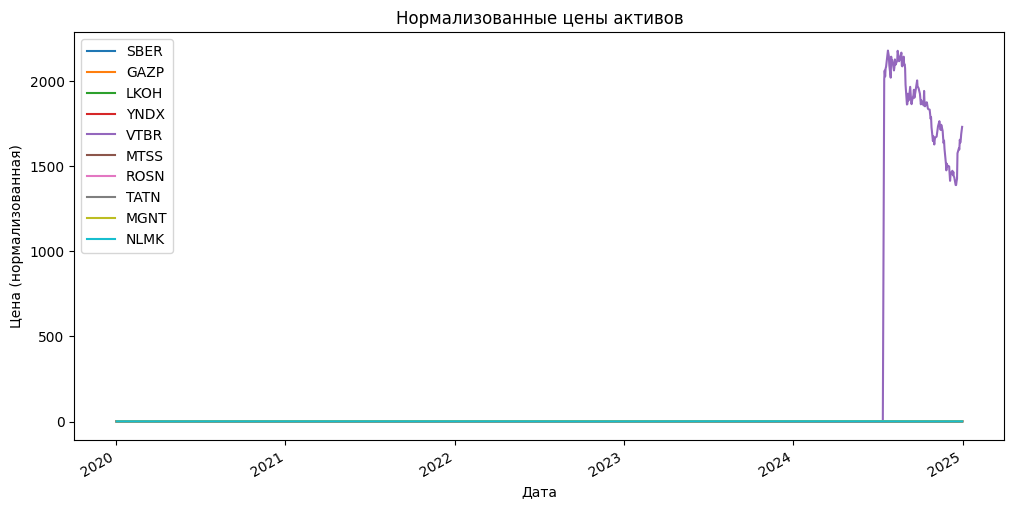

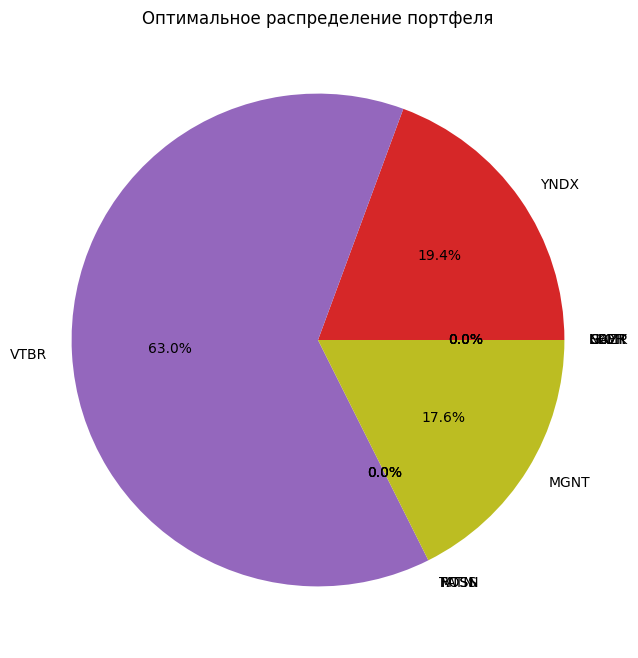

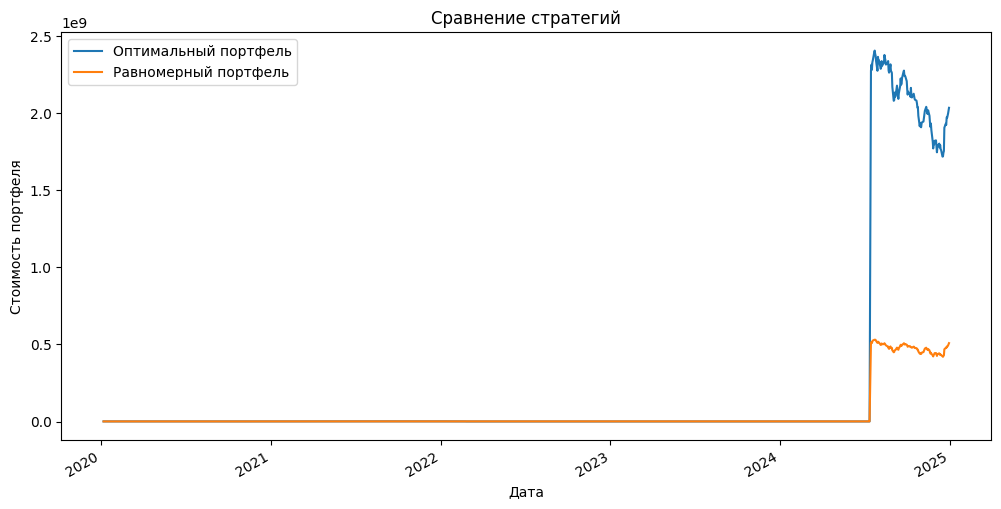

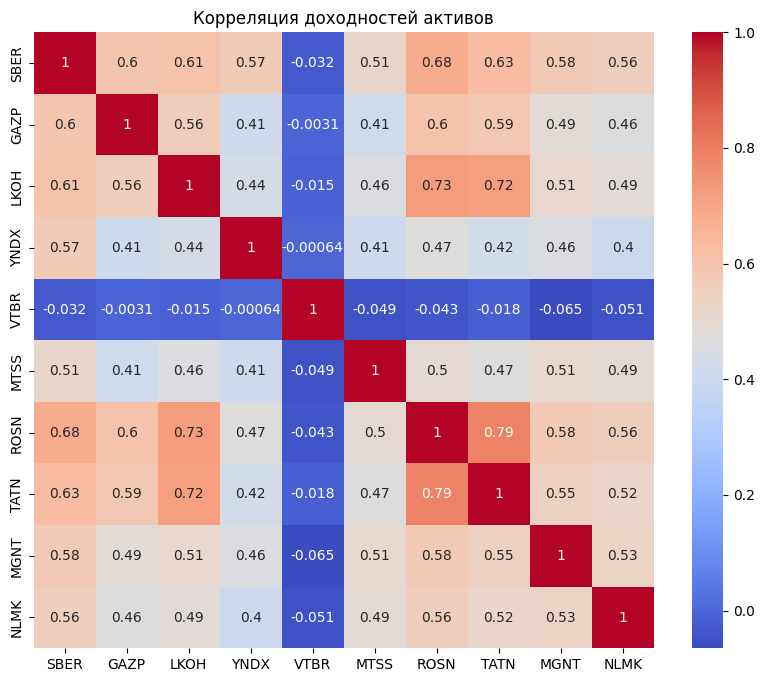

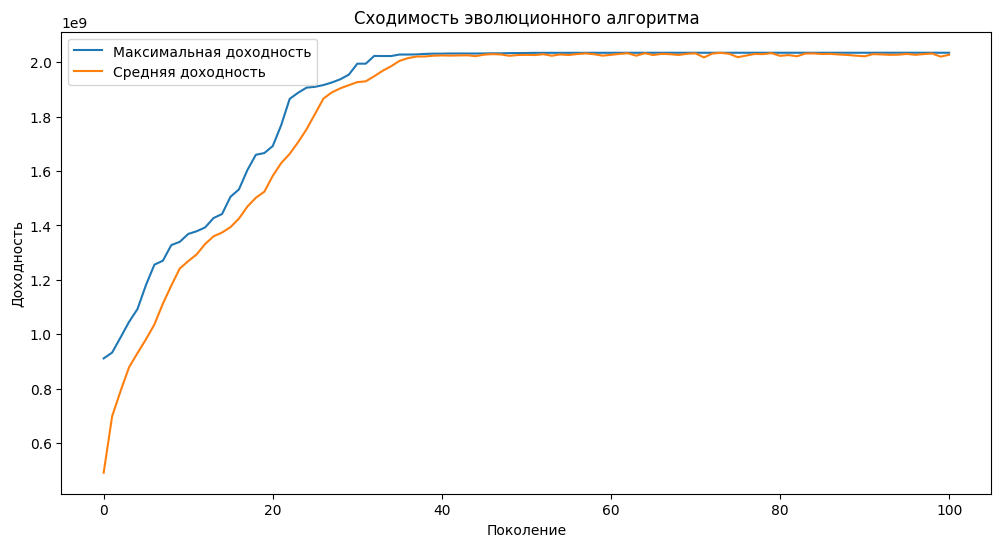

IndexError: invalid index to scalar variable.

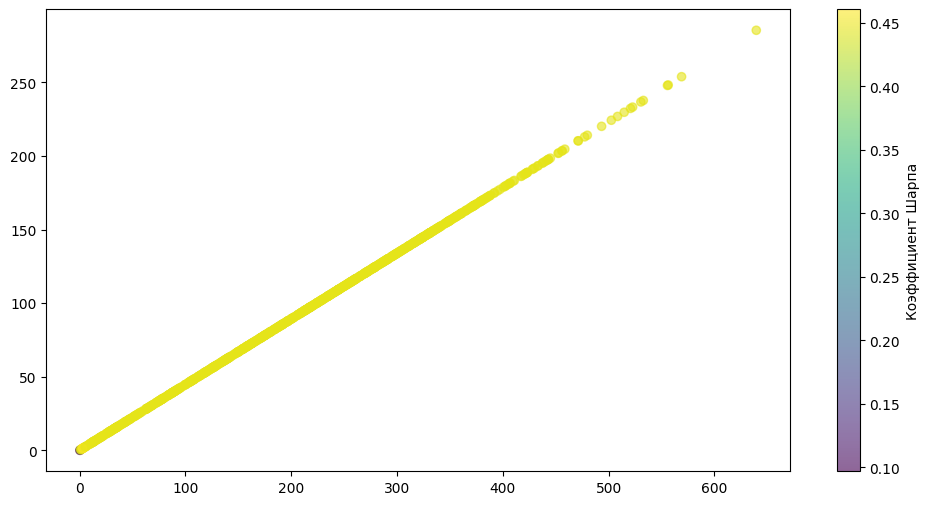

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# График цен акций
(data / data.iloc[0]).plot(figsize=(12, 6))
plt.title('Нормализованные цены активов')
plt.xlabel('Дата')
plt.ylabel('Цена (нормализованная)')
plt.show()

# Круговая диаграмма весов портфеля
plt.figure(figsize=(8, 8))
plt.pie(best_weights, labels=tickers, autopct='%1.1f%%')
plt.title('Оптимальное распределение портфеля')
plt.show()

# График роста портфеля
portfolio_growth = initial_capital * (1 + (returns * best_weights).sum(axis=1)).cumprod()
plt.figure(figsize=(12, 6))
portfolio_growth.plot(label='Оптимальный портфель')
(initial_capital * (1 + returns.mean(axis=1)).cumprod()).plot(label='Равномерный портфель')
plt.title('Сравнение стратегий')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля')
plt.legend()
plt.show()

# Матрица корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция доходностей активов')
plt.show()

# График сходимости алгоритма
plt.figure(figsize=(12, 6))
plt.plot(log.select('max'), label='Максимальная доходность')
plt.plot(log.select('avg'), label='Средняя доходность')
plt.title('Сходимость эволюционного алгоритма')
plt.xlabel('Поколение')
plt.ylabel('Доходность')
plt.legend()
plt.show()

# Риск-доходность
random_portfolios = []
for _ in range(1000):
    weights = normalize([random.random() for _ in range(num_assets)])
    preturns = (returns * weights).sum(axis=1)
    random_portfolios.append((
        preturns.mean() * 252,
        preturns.std() * np.sqrt(252),
        (1 + preturns).cumprod().iloc[-1]
    ))

sharpes = [(rp[0]-0.06)/rp[1] for rp in random_portfolios]

plt.figure(figsize=(12, 6))
plt.scatter([rp[1] for rp in random_portfolios],
            [rp[0] for rp in random_portfolios],
            c=sharpes, cmap='viridis', alpha=0.6)
plt.colorbar(label='Коэффициент Шарпа')
best_rp = evaluate_portfolio(best_weights)[0]/initial_capital
plt.scatter(best_rp[1], best_rp[0], c='red', s=100, marker='*', label='Оптимальный портфель')
plt.title('Диаграмма риск-доходность')
plt.xlabel('Волатильность')
plt.ylabel('Доходность')
plt.legend()
plt.show()

Ошибка загрузки GOLD: Expecting value: line 1 column 1 (char 0)
Ошибка загрузки SILV: Expecting value: line 1 column 1 (char 0)
Успешно загружены данные:
 ['SBER', 'GAZP', 'LKOH', 'VTBR', 'MGNT']

Первые 5 строк данных:
              SBER    GAZP    LKOH      VTBR    MGNT
TRADEDATE                                           
2020-01-03  255.00  259.00  6294.0  0.046240  3445.5
2020-01-06  253.90  256.55  6382.0  0.046110  3416.0
2020-01-08  259.15  255.79  6496.5  0.046525  3427.0
2020-01-09  257.99  254.07  6430.0  0.047075  3348.0
2020-01-10  258.19  251.90  6490.0  0.047600  3319.5
Количество активов в портфеле: 5
Список активов: ['SBER', 'GAZP', 'LKOH', 'VTBR', 'MGNT']
Размерность returns: (1010, 5)
Количество весов в особи: 5
gen	nevals	max    	avg    
0  	50    	1.41767	1.03229
1  	40    	1.66098	1.21791
2  	39    	1.66098	1.33754
3  	38    	2.0256 	1.43898
4  	37    	2.39677	1.54032
5  	42    	2.53232	1.69666
6  	40    	3.3186 	1.85587
7  	42    	3.3186 	2.09855
8  	38    	3.6927

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


21 	36    	6.16537	5.46803
22 	43    	6.24262	5.51429
23 	34    	6.40393	5.4707 
24 	38    	6.40393	5.69467
25 	39    	6.40393	5.45347
26 	39    	6.5814 	5.89545
27 	39    	6.5814 	5.88385
28 	45    	6.6529 	5.67691
29 	37    	7.06054	6.19689
30 	42    	7.21825	6.18437
31 	39    	7.28844	6.52182
32 	41    	7.28844	6.66727
33 	42    	7.31011	6.80504
34 	37    	7.38953	6.8932 
35 	44    	7.56939	6.78263
36 	36    	7.79469	6.55774
37 	42    	7.79469	6.9715 
38 	38    	7.79469	7.35378
39 	44    	7.9902 	7.25745
40 	46    	8.32446	7.41488
41 	43    	8.32446	7.24612
42 	39    	8.32446	7.50583
43 	41    	8.64878	7.38071
44 	41    	8.64878	7.64187
45 	41    	8.65554	7.2408 
46 	41    	8.91569	7.34443
47 	44    	8.95343	7.42313
48 	43    	8.95762	7.26975
49 	39    	8.95762	7.28553
50 	33    	8.9005 	7.97608
51 	43    	9.04005	8.20741
52 	31    	8.99175	8.23658
53 	37    	9.10342	8.28237
54 	40    	9.06121	8.55969
55 	40    	9.09616	8.33609
56 	40    	9.12067	8.58652
57 	42    	9.13675	8.54392
5

<Figure size 1400x700 with 0 Axes>

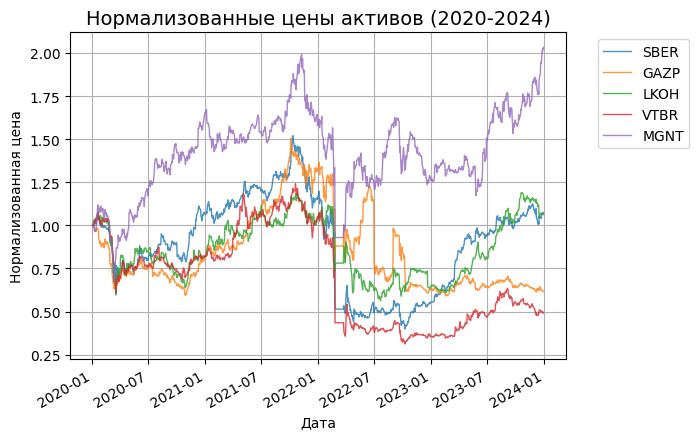

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


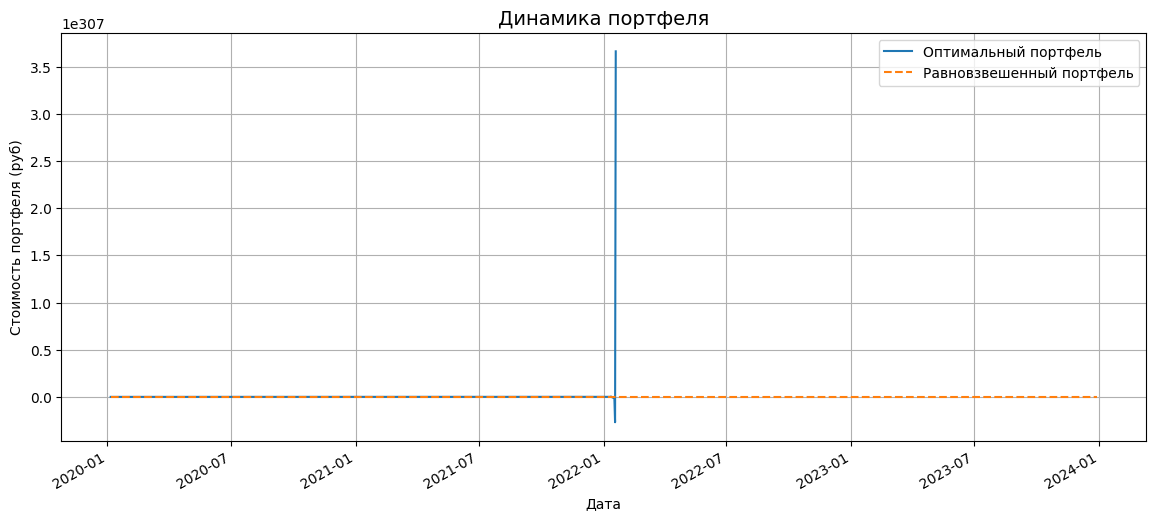

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:56: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


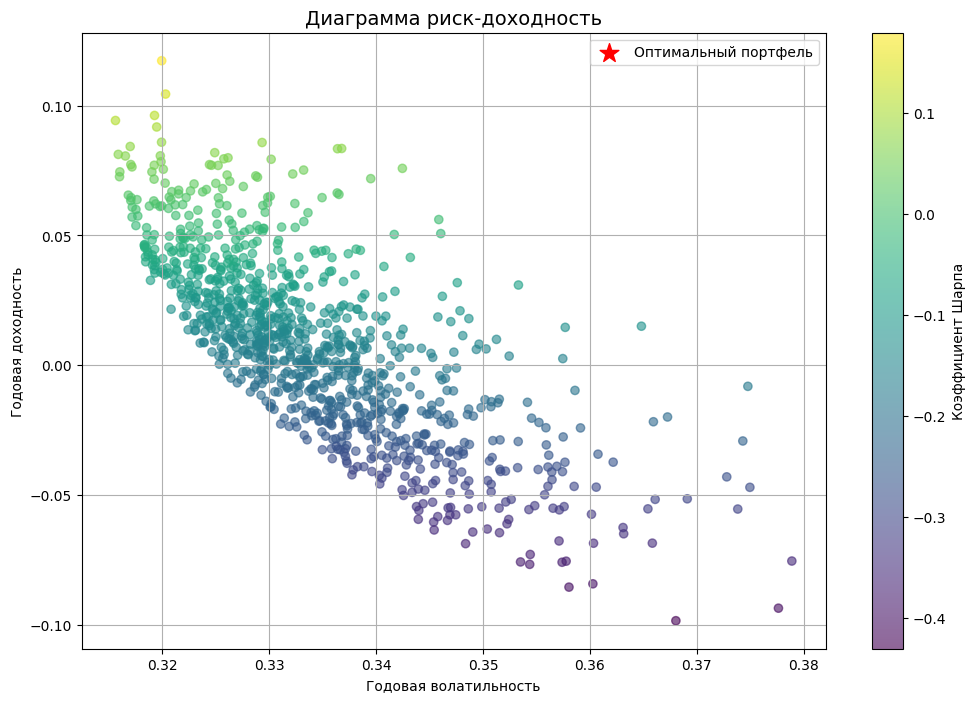

ValueError: Wedge sizes 'x' must be non negative values

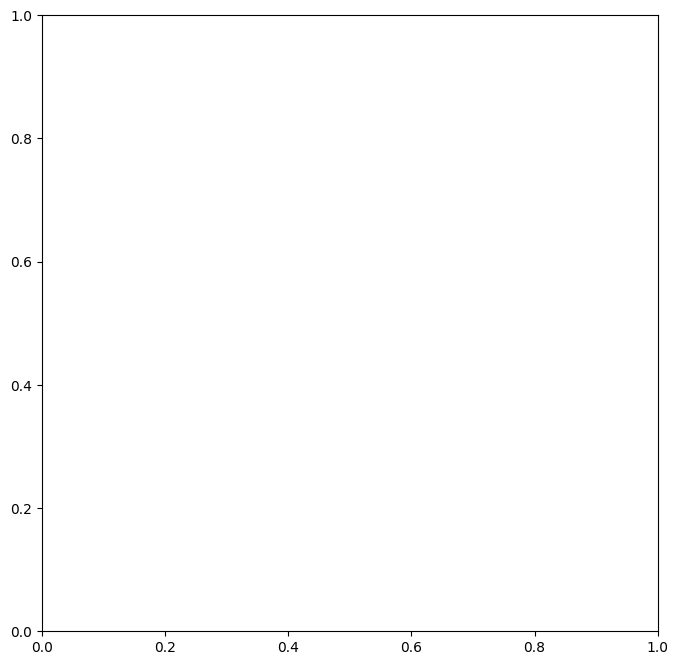

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime

# Конфигурация инструментов с правильными тикерами MOEX
assets = {
    'Акции': {
        'SBER': {'board': 'TQBR'},
        'GAZP': {'board': 'TQBR'},
        'LKOH': {'board': 'TQBR'},
        'VTBR': {'board': 'TQBR'},
        'MGNT': {'board': 'TQBR'}
    },
    'Валюта': {
        'USD/RUB': {'board': 'CETS', 'secid': 'USD000UTSTOM'},
        'EUR/RUB': {'board': 'CETS', 'secid': 'EUR_RUB__TOM'}
    },
    'Металлы': {
        'GOLD': {'board': 'MCT', 'market': 'forts', 'engine': 'currency'},
        'SILV': {'board': 'MCT', 'market': 'forts', 'engine': 'currency'}
    }
}

def fetch_data(asset_type, ticker, params):
    try:
        config = assets[asset_type][ticker]
        url = f"https://iss.moex.com/iss/history/engines/{config.get('engine', 'stock')}/markets/{config.get('market', 'shares')}/boards/{config['board']}/securities/{config.get('secid', ticker)}.json"

        data = []
        while True:
            response = requests.get(url, params=params)
            response.raise_for_status()
            json_data = response.json()

            # Ищем раздел с данными
            for key in ['history', 'securities', 'marketdata']:
                if key in json_data:
                    columns = json_data[key]['columns']
                    rows = json_data[key]['data']
                    break
            else:
                break

            # Обработка даты
            date_column = 'TRADEDATE' if 'TRADEDATE' in columns else 'tradedate'
            df = pd.DataFrame(rows, columns=columns)
            df[date_column] = pd.to_datetime(df[date_column])
            df.set_index(date_column, inplace=True)

            # Выбор цены закрытия
            price_column = 'CLOSE' if 'CLOSE' in columns else 'close'
            series = df[price_column].rename(ticker)

            data.append(series)
            if len(rows) < params['limit']:
                break
            params['start'] += params['limit']

        return pd.concat(data) if data else pd.Series()

    except Exception as e:
        print(f'Ошибка загрузки {ticker}: {str(e)}')
        return pd.Series()

# Параметры загрузки
params = {
    'from': '2020-01-01',
    'till': '2024-01-01',
    'iss.meta': 'off',
    'limit': 100,
    'start': 0
}

# Сбор данных
data_frames = []
for asset_type in assets:
    for ticker in assets[asset_type]:
        series = fetch_data(asset_type, ticker, params.copy())
        if not series.empty:
            data_frames.append(series)

data = pd.concat(data_frames, axis=1).ffill().dropna()
print("Успешно загружены данные:\n", data.columns.tolist())

# Визуализация первых строк данных
print("\nПервые 5 строк данных:")
print(data.head())

# 3. Расчет доходностей
returns = data.pct_change().dropna()

# 4. Модифицированный эволюционный алгоритм с ограничениями
# После загрузки данных
num_assets = data.shape[1]  # Динамическое определение количества активов
print(f"Количество активов в портфеле: {num_assets}")

# Обновленная функция оценки
def evaluate_portfolio(weights):
    try:
        # Нормализация весов перед расчетами
        norm_weights = np.array(weights) / np.sum(weights)
        portfolio_returns = returns.dot(norm_weights)
        cumulative_return = (1 + portfolio_returns).cumprod().iloc[-1]
        return (cumulative_return,)
    except Exception as e:
        print(f"Ошибка в evaluate_portfolio: {str(e)}")
        return (0.0,)  # Возвращаем 0 в случае ошибки

# Обновленная конфигурация DEAP
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('attr_float', random.uniform, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_assets)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# Проверка соответствия размерностей
assert len(returns.columns) == num_assets, "Количество активов не совпадает с данными!"

print("Список активов:", data.columns.tolist())
print("Размерность returns:", returns.shape)
print("Количество весов в особи:", len(toolbox.individual()))

def normalize(individual):
    total = sum(individual)
    return [w/total for w in individual] if total > 0 else [1/num_assets]*num_assets

toolbox.register('evaluate', lambda ind: evaluate_portfolio(normalize(ind)))
toolbox.register('mate', tools.cxBlend, alpha=0.5)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register('max', np.max)
stats.register('avg', np.mean)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3,
                              ngen=100, stats=stats,
                              halloffame=hof, verbose=True)

best_weights = normalize(hof[0])
print(best_weights)

# 5. Исправленные визуализации
plt.figure(figsize=(14,7))
(data / data.iloc[0]).plot(lw=1, alpha=0.8)
plt.title('Нормализованные цены активов (2020-2024)', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Нормализованная цена')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# График роста портфеля
initial_capital = 1000000
portfolio_value = initial_capital * (1 + (returns * best_weights).sum(axis=1)).cumprod()
benchmark = initial_capital * (1 + returns.mean(axis=1)).cumprod()

plt.figure(figsize=(14,6))
portfolio_value.plot(label='Оптимальный портфель')
benchmark.plot(label='Равновзвешенный портфель', ls='--')
plt.title('Динамика портфеля', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (руб)')
plt.legend()
plt.grid(True)
plt.show()

# Исправленная диаграмма риск-доходность
def calculate_risk_return(weights):
    preturns = (returns * weights).sum(axis=1)
    annual_return = (1 + preturns).prod()**(252/len(returns)) - 1
    annual_volatility = preturns.std() * np.sqrt(252)
    return annual_return, annual_volatility

random_portfolios = []
for _ in range(1000):
    weights = normalize([random.random() for _ in range(num_assets)])
    ret, vol = calculate_risk_return(weights)
    random_portfolios.append((ret, vol))

# Расчет для оптимального портфеля
best_ret, best_vol = calculate_risk_return(best_weights)

plt.figure(figsize=(12,8))
plt.scatter([rp[1] for rp in random_portfolios],
            [rp[0] for rp in random_portfolios],
            c=[(rp[0]-0.06)/rp[1] for rp in random_portfolios],
            cmap='viridis', alpha=0.6)
plt.colorbar(label='Коэффициент Шарпа')
plt.scatter(best_vol, best_ret, c='red', s=200, marker='*', label='Оптимальный портфель')
plt.title('Диаграмма риск-доходность', fontsize=14)
plt.xlabel('Годовая волатильность')
plt.ylabel('Годовая доходность')
plt.legend()
plt.grid(True)
plt.show()

# Круговая диаграмма весов портфеля
plt.figure(figsize=(8, 8))
plt.pie(best_weights, labels=tickers, autopct='%1.1f%%')
plt.title('Оптимальное распределение портфеля')
plt.show()

# Матрица корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция доходностей активов')
plt.show()

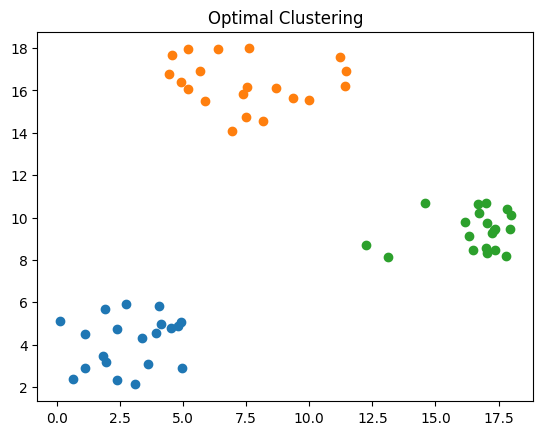

Best solution is [ 3.14446253  4.27030814  7.4178121  16.11199977 17.12033982  9.43108213]
Fitness of the best solution is 0.00932255021011336
Best solution found after 80 generations


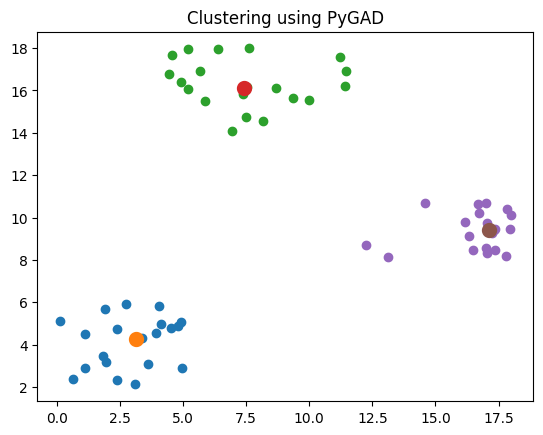

In [ ]:
import numpy
import matplotlib.pyplot
!pip install pygad
import pygad

cluster1_num_samples = 20
cluster1_x1_start = 0
cluster1_x1_end = 5
cluster1_x2_start = 2
cluster1_x2_end = 6
cluster1_x1 = numpy.random.random(size=(cluster1_num_samples))
cluster1_x1 = cluster1_x1 * (cluster1_x1_end - cluster1_x1_start) + cluster1_x1_start
cluster1_x2 = numpy.random.random(size=(cluster1_num_samples))
cluster1_x2 = cluster1_x2 * (cluster1_x2_end - cluster1_x2_start) + cluster1_x2_start

cluster2_num_samples = 20
cluster2_x1_start = 4
cluster2_x1_end = 12
cluster2_x2_start = 14
cluster2_x2_end = 18
cluster2_x1 = numpy.random.random(size=(cluster2_num_samples))
cluster2_x1 = cluster2_x1 * (cluster2_x1_end - cluster2_x1_start) + cluster2_x1_start
cluster2_x2 = numpy.random.random(size=(cluster2_num_samples))
cluster2_x2 = cluster2_x2 * (cluster2_x2_end - cluster2_x2_start) + cluster2_x2_start

cluster3_num_samples = 20
cluster3_x1_start = 12
cluster3_x1_end = 18
cluster3_x2_start = 8
cluster3_x2_end = 11
cluster3_x1 = numpy.random.random(size=(cluster3_num_samples))
cluster3_x1 = cluster3_x1 * (cluster3_x1_end - cluster3_x1_start) + cluster3_x1_start
cluster3_x2 = numpy.random.random(size=(cluster3_num_samples))
cluster3_x2 = cluster3_x2 * (cluster3_x2_end - cluster3_x2_start) + cluster3_x2_start

c1 = numpy.array([cluster1_x1, cluster1_x2]).T
c2 = numpy.array([cluster2_x1, cluster2_x2]).T
c3 = numpy.array([cluster3_x1, cluster3_x2]).T

data = numpy.concatenate((c1, c2, c3), axis=0)

matplotlib.pyplot.scatter(cluster1_x1, cluster1_x2)
matplotlib.pyplot.scatter(cluster2_x1, cluster2_x2)
matplotlib.pyplot.scatter(cluster3_x1, cluster3_x2)
matplotlib.pyplot.title("Optimal Clustering")
matplotlib.pyplot.show()

def euclidean_distance(X, Y):
    return numpy.sqrt(numpy.sum(numpy.power(X - Y, 2), axis=1))

def cluster_data(solution, solution_idx):
    global num_clusters, feature_vector_length, data
    cluster_centers = []
    all_clusters_dists = []
    clusters = []
    clusters_sum_dist = []

    for clust_idx in range(num_clusters):
        cluster_centers.append(solution[feature_vector_length*clust_idx:feature_vector_length*(clust_idx+1)])
        cluster_center_dists = euclidean_distance(data, cluster_centers[clust_idx])
        all_clusters_dists.append(numpy.array(cluster_center_dists))

    cluster_centers = numpy.array(cluster_centers)
    all_clusters_dists = numpy.array(all_clusters_dists)

    cluster_indices = numpy.argmin(all_clusters_dists, axis=0)
    for clust_idx in range(num_clusters):
        clusters.append(numpy.where(cluster_indices == clust_idx)[0])
        if len(clusters[clust_idx]) == 0:
            clusters_sum_dist.append(0)
        else:
            clusters_sum_dist.append(numpy.sum(all_clusters_dists[clust_idx, clusters[clust_idx]]))

    clusters_sum_dist = numpy.array(clusters_sum_dist)

    return cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist

def fitness_func(ga_instance, solution, solution_idx):
    _, _, _, _, clusters_sum_dist = cluster_data(solution, solution_idx)

    fitness = 1.0 / (numpy.sum(clusters_sum_dist) + 0.00000001)

    return fitness

num_clusters = 3
feature_vector_length = data.shape[1]
num_genes = num_clusters * feature_vector_length

ga_instance = pygad.GA(num_generations=100,
                       sol_per_pop=10,
                       init_range_low=0,
                       init_range_high=20,
                       num_parents_mating=5,
                       keep_parents=2,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       suppress_warnings=True)

ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist = cluster_data(best_solution, best_solution_idx)

for cluster_idx in range(num_clusters):
    cluster_x = data[clusters[cluster_idx], 0]
    cluster_y = data[clusters[cluster_idx], 1]
    matplotlib.pyplot.scatter(cluster_x, cluster_y)
    matplotlib.pyplot.scatter(cluster_centers[cluster_idx, 0], cluster_centers[cluster_idx, 1], linewidths=5)
matplotlib.pyplot.title("Clustering using PyGAD")
matplotlib.pyplot.show()

In [ ]:
import sklearn.datasets

images, target = sklearn.datasets.load_digits(return_X_y=True, as_frame=True)
print(images.shape)

import numpy as np

X, y_true = images, target.astype(int)
X = X.astype(np.float32) / 255.0

(1797, 64)


In [ ]:
import umap
!pip install umap-learn[plot]
import umap.plot
from umap import UMAP
import time
from sklearn.metrics import adjusted_rand_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

In [ ]:
umap_3d_embeddings = UMAP(n_components=3, random_state=7).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
data = umap_3d_embeddings

def euclidean_distance(X, Y):
    return numpy.sqrt(numpy.sum(numpy.power(X - Y, 2), axis=1))

def cluster_data(solution, solution_idx):
    global num_clusters, feature_vector_length, data
    cluster_centers = []
    all_clusters_dists = []
    clusters = []
    clusters_sum_dist = []

    for clust_idx in range(num_clusters):
        cluster_centers.append(solution[feature_vector_length*clust_idx:feature_vector_length*(clust_idx+1)])
        cluster_center_dists = euclidean_distance(data, cluster_centers[clust_idx])
        all_clusters_dists.append(numpy.array(cluster_center_dists))

    cluster_centers = numpy.array(cluster_centers)
    all_clusters_dists = numpy.array(all_clusters_dists)

    cluster_indices = numpy.argmin(all_clusters_dists, axis=0)
    for clust_idx in range(num_clusters):
        clusters.append(numpy.where(cluster_indices == clust_idx)[0])
        if len(clusters[clust_idx]) == 0:
            clusters_sum_dist.append(0)
        else:
            clusters_sum_dist.append(numpy.sum(all_clusters_dists[clust_idx, clusters[clust_idx]]))

    clusters_sum_dist = numpy.array(clusters_sum_dist)

    return cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist

def fitness_func(ga_instance, solution, solution_idx):
    _, _, cluster_indices, _, clusters_sum_dist = cluster_data(solution, solution_idx)

    #fitness = 1.0 / (numpy.sum(clusters_sum_dist) + 0.00000001)

    return adjusted_rand_score(y_true, cluster_indices)

num_clusters = 10
feature_vector_length = data.shape[1]
num_genes = num_clusters * feature_vector_length

ga_instance = pygad.GA(num_generations=1000,
                       sol_per_pop=60,
                       init_range_low=-10,
                       init_range_high=20,
                       num_parents_mating=50,
                       keep_parents=40,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       suppress_warnings=True)

ga_instance.run()

best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution is {bs}".format(bs=best_solution))
print("Fitness of the best solution is {bsf}".format(bsf=best_solution_fitness))
print("Best solution found after {gen} generations".format(gen=ga_instance.best_solution_generation))

cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist = cluster_data(best_solution, best_solution_idx)

Best solution is [-7.74562508  5.68455889  2.46472237 12.65804062  2.75200955 -6.90079892
 -2.05219515 -0.35836831 -2.84506842  1.75502516 20.15728642  8.05914474
 -6.33859241 -0.46505867  8.86922512 -1.40287764 15.98550657 11.86220405
 15.46742299 -1.92981586  6.70081014  6.54787694 -0.41997251 11.00611419
 -9.42926674  8.7627924  12.05175321  4.64631627 31.71084661 -9.89311473]
Fitness of the best solution is 0.8352716513314585
Best solution found after 810 generations


In [ ]:
print(np.unique(cluster_indices))

[0 1 2 3 4 5 6 7 8]


In [ ]:
print(adjusted_rand_score(y_true, cluster_indices))

0.8352716513314585


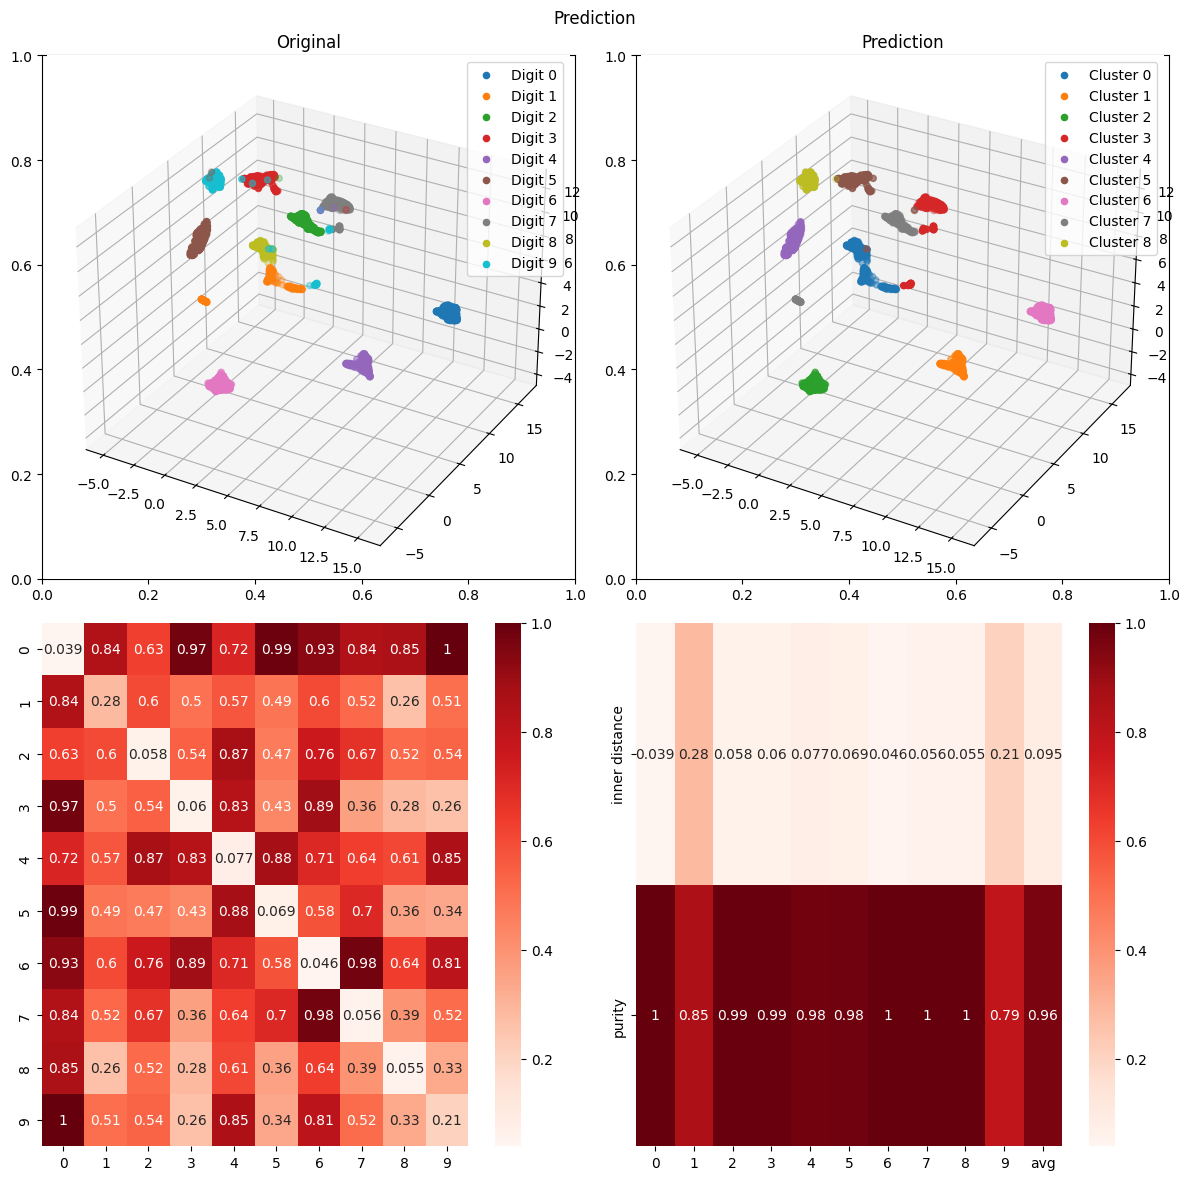

In [ ]:
from sklearn.metrics import pairwise_distances
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

def class_purity(y_true, y_pred, cls):
    class_mask = (y_true == cls)
    class_predictions = y_pred[class_mask]
    cluster_counts = Counter(class_predictions)
    purity = max(cluster_counts.values()) / len(class_predictions)
    return purity

def plot_clustering(title, X, y_true, y_pred, metric):
    fig, plots = plt.subplots(2, 2, figsize=(12,12))
    fig.suptitle(title)
    plt.prism()

    n_clusters = len(np.unique(y_true))
    purities = []

    ax = fig.add_subplot(2, 2, 1, projection='3d') if X.shape[1] == 3 else plots[0, 0]
    for i in range(n_clusters):
        digit_indices = (y_true == i)
        purities.append(class_purity(y_true, y_pred, i))
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Original')
        ax.scatter(*dims, label=f"Digit {i}")
        ax.legend()

    purities.append(np.average(purities))

    avg_dist = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y_true == i], X[y_true == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    sns.heatmap(avg_dist, ax=plots[1, 0], annot=True, cmap='Reds', xticklabels=np.arange(n_clusters), yticklabels=np.arange(n_clusters))

    inner_distances = [avg_dist[i, i] for i in range(n_clusters)]
    inner_distances.append(np.average(inner_distances))
    sns.heatmap([inner_distances, purities], ax=plots[1, 1], annot=True, cmap='Reds', xticklabels=[*np.arange(n_clusters), 'avg'], yticklabels=['inner distance', 'purity'])

    n_clusters = len(np.unique(y_pred))

    ax = fig.add_subplot(2, 2, 2, projection='3d') if X.shape[1] == 3 else plots[0, 1]
    for i in range(n_clusters):
        digit_indices = (y_pred == i)
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Prediction')
        ax.scatter(*dims, label=f"Cluster {i}")
        ax.legend()

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

plot_clustering('Prediction', data, y_true, cluster_indices, 'euclidean')

/usr/local/lib/python3.11/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


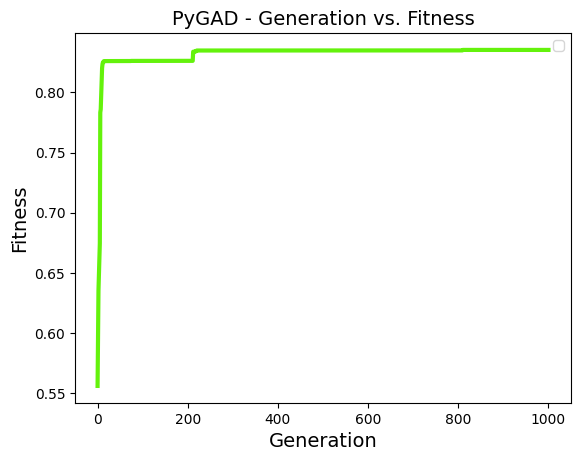

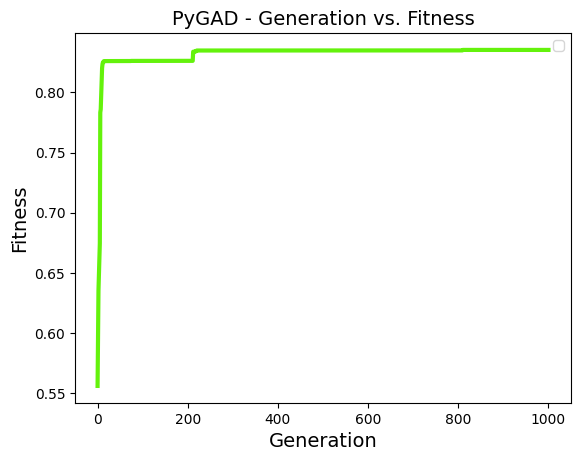

In [ ]:
ga_instance.plot_fitness()